<a href="https://colab.research.google.com/github/ishangurtu/Image-Captioning-using-NLP-and-CV/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connecting drive to colab to access dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing important libraries and models

import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  
import tensorflow as tf
from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
from keras.models import load_model



from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from pickle import load



In [ ]:
# Defining basic variables

epoch_no = 20
START = "startseq" # to know where to start generating captions
STOP = "endseq"   # to know where to stop generating captions
INCEPTION = True

In [ ]:
# Formatted time string to calculate, know and display time elapsed

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [ ]:
# Loading and cleaning data from whitespaces, punctuations etc

null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join('/content/drive/My Drive/Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [ ]:
print(len(lex)) # The dictionary length
print(max_length) # Max length of a caption
print(len(lookup)) # Number of unique words


8763
32
8092


In [ ]:
# Load glove embeddings

img = glob.glob(os.path.join('/content/drive/My Drive/Flicker8k_Dataset', '*.jpg'))

In [ ]:
len(img)

8091

In [ ]:
# Read all image names and use the predefined train/test sets to put them in a list respectively.

train_images_path = os.path.join('/content/drive/My Drive/Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join('/content/drive/My Drive/Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [ ]:
# Showing Length of train and test images(Number of them)

print(len(train_images))
print(len(test_images))

6000
1000


In [ ]:
# Create start/stop sequences. Include a start and stop keyword(token) at the beginning and end respectively.
# We will later use the start token to begin the process of generating a caption. The stop token in the generated text will let us know the process is complete.

train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
# Loading Inception V3 model for transfer learning to reduce training and specifying image and output layer dimensions.

if INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# printing model architecture summary and number of features
encode_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# We need to encode the images to create the training set. Later we will encode new images to present them for captioning.

def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

We can how to generate the training set, which will involve looping over every JPG that we provided. Because this can take a while to perform, we will save it to a pickle file. This saved file prevents the considerable time needed to reprocess all of the images again. Because the images are processed differently by different transferred neural networks, the filename contains the output dimensions. We follow this naming convention because if you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and you must reprocess the images.

In [ ]:

train_path = os.path.join(f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join('/content/drive/My Drive/Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [1:01:17<00:00,  1.63it/s]



Generating training set took: 1:01:17.44


In [ ]:
# Repeat same for test images

test_path = os.path.join(f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join('/content/drive/My Drive/Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]


Generating testing set took: 0:06:27.99


In [ ]:
# Loading the pickle files

pickle_in = open("/content/drive/My Drive/IC/train2048.pkl","rb")
encoding_train = pickle.load(pickle_in)

pickl  =  open("/content/drive/My Drive/IC/test2048.pkl","rb")
encoding_test = pickle.load(pickl)

In [ ]:
#Downloading pickle file to system

from google.colab import files

files.download('train2048.pkl') 
files.download('test2048.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Separate the captions that we will use for training. There are two sides to this training, the images, and the captions.
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Removing words that don't occur often to remove misleading

word_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [ ]:
# Making two tables to convert word to index and vice versa.

indextoword = {}

wordtoindex = {}

ix = 1
for w in vocab:
    wordtoindex[w] = ix
    indextoword[ix] = w
    ix += 1
    
vocab_size = len(indextoword) + 1 
vocab_size

1652

In [ ]:
max_length +=2
print(max_length)

34


Up to this point, we've always generated training data ahead of time and fit the neural network to it. It is not always practical to create all of the training data ahead of time.
The memory demands can be considerable. If we generate the training data as the neural network needs it, it is possible to use a Keras generator. 
The generator will create new data as it is needed. The generator provided here creates the training data for the caption neural network, as it is needed.


In [ ]:
# Here we are just training on two captions. However, we would have to duplicate the image for each of these partial captions that we have.
#Additionally, the Flikr8K data set has five captions for each picture. Those would all require duplication of data as well. 
#It is much more efficient to generate the data as needed.

def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [ ]:
# Loading Glove Embeddings

embeddings_index = {} 
f = open(os.path.join('/content/drive/My Drive/Project/IC/glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:22, 17812.95it/s]

Found 400000 word vectors.


In [ ]:
# Converting to pickle and downloading it

pickle.dump(embeddings_index, open('embeddings_index.pkl', 'wb'))

In [ ]:
from google.colab import files
files.download('embeddings_index.pkl') 

#TO access pickle file:
#pickle_in = open("embeddings_index.pkl","rb")
#embeddings_index = pickle.load(pickle_in)

In [ ]:
# We build an embedding matrix from Glove. We will directly copy this matrix to the weight matrix of the neural network.

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoindex.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
# Print embedding matrix shape

embedding_matrix.shape

(1652, 200)

In [ ]:
# Creating our Model

def define_model(vocab_size, max_length):

  inputs1 = Input(shape=(OUTPUT_DIM,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.layers[2].set_weights([embedding_matrix])
  model.layers[2].trainable = False
  model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
  print(model.summary())
  return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:

embedding_dim

200

In [ ]:
number_pics_per_bath = 3


In [ ]:
# Training our model and saving it for each epoch to get the best model

epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
6000/6000 [==============================] - 488s 81ms/step - loss: 2.3382


In [ ]:
# Loading the 14th(iteration) model as it worked best. Load it in your system.

new_model = tf.keras.models.load_model('model_13.h5')


In [ ]:
# Function to generate Captions of less than max length for each image given

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoindex[w] for w in in_text.split() if w in wordtoindex]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = new_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = indextoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/My Drive/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg


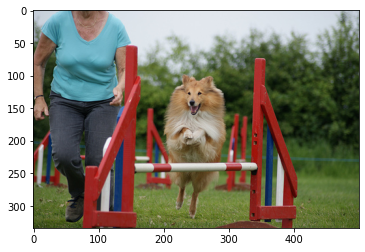

Caption: dog jumps over hurdle
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/3567061016_62768dcce1.jpg


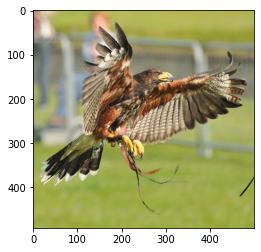

Caption: dog is jumping over an obstacle
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg


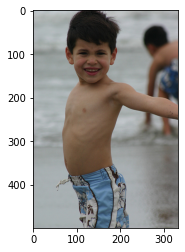

Caption: boy in swimming trunks is jumping into the water
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/3514019869_7de4ece2a5.jpg


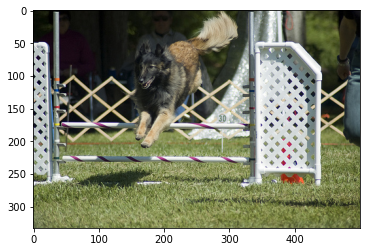

Caption: dog is jumping over red and white gate
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/2265096094_8cc34d669c.jpg


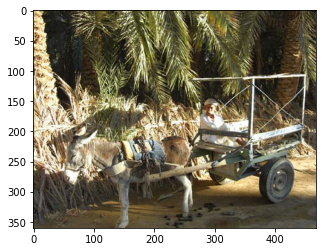

Caption: two people are riding horses upside down on the ground
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/3591462960_86045906bd.jpg


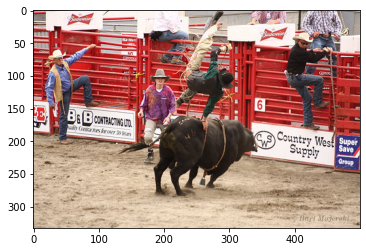

Caption: two children are playing with tall fence in the grass
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/416106657_cab2a107a5.jpg


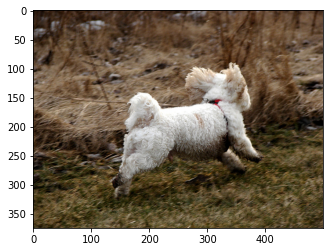

Caption: white dog is running through the grass
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/2918769188_565dd48060.jpg


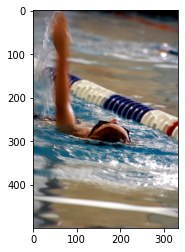

Caption: boy in swimming trunks splashes in the water
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/3530843182_35af2c821c.jpg


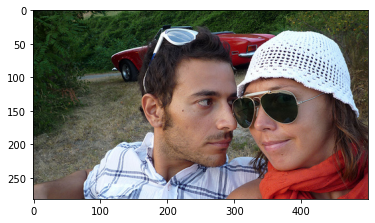

Caption: man in white shirt and sunglasses is holding up peace sign
_____________________________________
/content/drive/My Drive/Flicker8k_Dataset/2396691909_6b8c2f7c44.jpg


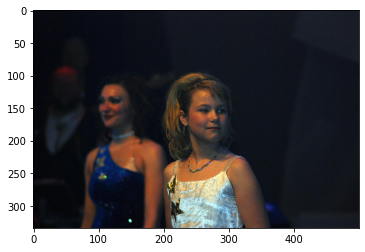

Caption: two girls are smiling and waving
_____________________________________


In [ ]:
# Test Caption generation on random 10 images

for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join('/content/drive/My Drive/Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join('/content/drive/My Drive/Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb